# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'Fv'
folder = 'MP-Fv-500-T'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std':      f'{r_folder}/ref_dataset_std.pt',
    'r_std_parameters':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data': f'{r_folder}/uncertainty_data.json',
    'model':              f'{r_folder}/model.pt',
    'dataset_parameters': f'{r_folder}/dataset_parameters.json',
    't_dataset':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
# Note that you can as well load a non-standardized dataset and
# then use the cld.standardize_dataset_from_keys function
r_dataset_std = torch.load(files_names['r_dataset_std'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dataset_parameters'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Target dataset

In [5]:
# Load the standardized dataset, with corresponding labels and parameters
# We provide the cld.generate_dataset to generate the dataset
# from an existing database if this does not exist yet
t_dataset = torch.load(files_names['t_dataset'], weights_only=False)

# Extract the ground-truths, or input them manually
# This is only requested for testing the performance of the method, not for actual production
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(5, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [44]:
import importlib
importlib.reload(clm)

<module 'libraries.model' from '/home/claudio/cibran/Work/UPC/CLUE/libraries/model.py'>

In [45]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, are_interpolated = clm.forward_predictions(r_dataset_std,
                                                                       t_dataset_std,
                                                                       model, r_std_parameters, r_uncertainty_data)

# Plot predictions

In [ ]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = np.abs(uncertainties[are_interpolated])

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = np.abs(uncertainties[~are_interpolated])

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-abs-prediction-comparison-500.pdf', dpi=50, bbox_inches='tight')
plt.show()

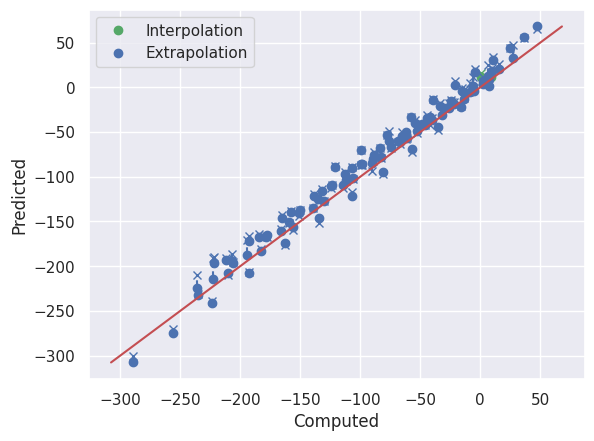

In [46]:
ground_truths = ground_truths[:100]
predictions = predictions[:100]
uncertainties = uncertainties[:100]
are_interpolated = are_interpolated[:100]

# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = uncertainties[are_interpolated]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
plt.plot(xpred_interp, ypred_interp + yerr_interp, 'xg')           # Corrected values
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = uncertainties[~are_interpolated]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
plt.plot(xpred_extra, ypred_extra + yerr_extra, 'xb')            # Corrected values
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison-500.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [ ]:
print('Extrapolated:')
for i, data in enumerate(t_dataset_std):
    if not are_interpolated[i]:
        print(data.label, ground_truths[i])

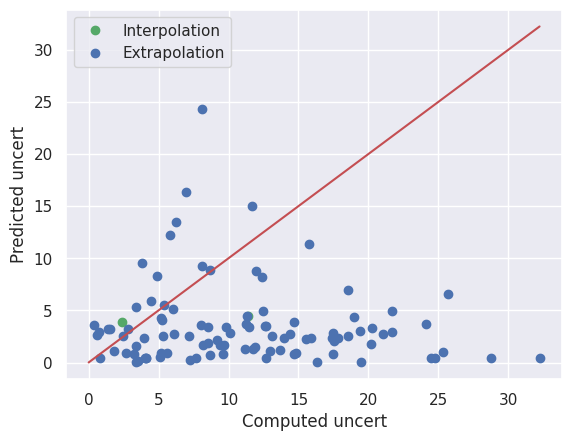

In [47]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()